In [1]:
import pandas as pd
import dask.dataframe as dd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, log_loss

In [2]:
def calculate_ctr(gt):
  positive = len([x for x in gt if x == True])
  ctr = positive/float(len(gt))
  return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

## Proof of concept of xgboost on 10% of dataset

In [3]:
%%time

columns = [
    'tweet_timestamp', 
    'creator_follower_count', 
    'creator_following_count',
    'creator_is_verified', 
    'creator_creation_timestamp',
    'engager_follower_count', 
    'engager_following_count',
    'engager_is_verified', 
    'engager_creation_timestamp',
    'engagement_creator_follows_engager', 
    'number_of_photo', 
    'number_of_gif', 
    'number_of_video',
    'mapped_language_id', 
    'mapped_tweet_type',
    'engagement_like_timestamp',
]

dask_df = dd.read_parquet("G:\RecSysChallenge2021\sample_dataset", engine='pyarrow', columns=columns)
dask_df['engagement_like_timestamp'] = dask_df['engagement_like_timestamp'] != -1

pandas_df = dask_df.compute()

del dask_df

pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34778851 entries, 0 to 405304
Data columns (total 16 columns):
 #   Column                              Dtype
---  ------                              -----
 0   tweet_timestamp                     int32
 1   creator_follower_count              int32
 2   creator_following_count             int32
 3   creator_is_verified                 bool 
 4   creator_creation_timestamp          int32
 5   engager_follower_count              int32
 6   engager_following_count             int32
 7   engager_is_verified                 bool 
 8   engager_creation_timestamp          int32
 9   engagement_creator_follows_engager  bool 
 10  number_of_photo                     uint8
 11  number_of_gif                       uint8
 12  number_of_video                     uint8
 13  mapped_language_id                  uint8
 14  mapped_tweet_type                   uint8
 15  engagement_like_timestamp           bool 
dtypes: bool(4), int32(7), uint8(5)
memor

In [4]:
train, test = train_test_split(pandas_df, train_size=0.8)

X_train = train.drop(['engagement_like_timestamp'], axis=1)
y_train = train['engagement_like_timestamp']#.astype(int)

X_test = test.drop(['engagement_like_timestamp'], axis=1)
y_test = test['engagement_like_timestamp']#.astype(int)

del pandas_df, train, test

In [5]:
%%time

classifier = xgb.XGBClassifier(
    tree_method='gpu_hist',
    gpu_id=0
).fit(X_train, y_train)

Wall time: 1min 29s


In [6]:
%%time

y_pred = classifier.predict(X_test)

Wall time: 11 s


In [7]:
print('RCE is {}'.format(compute_rce(y_pred, y_test)))
print('Average precision is {}'.format(average_precision_score(y_test, y_pred)))

RCE is -1723.5618538705044
Average precision is 0.46344513204401994


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

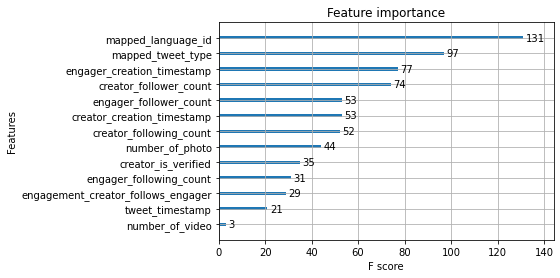

In [8]:
xgb.plot_importance(classifier)

In [9]:
import pickle

In [10]:
file_name="G:\RecSysChallenge2021\like"

In [11]:
pickle.dump(classifier, open(file_name, "wb"))

In [12]:
classifier = pickle.load(open(file_name, "rb"))

In [13]:
%%time

y_pred = classifier.predict(X_test)

Wall time: 10.2 s


In [14]:
print('RCE is {}'.format(compute_rce(y_pred, y_test)))
print('Average precision is {}'.format(average_precision_score(y_test, y_pred)))

RCE is -1723.5618538705044
Average precision is 0.46344513204401994


In [15]:
del X_train, y_train, X_test, y_test, classifier

## Train and save models to predict all the classes

In [16]:
classes = [
    'reply',
    'retweet', 
    'comment',
    'like'
]

class_columns = ['engagement_'+name+'_timestamp' for name in classes]

In [17]:
%%time

columns = [
    'tweet_timestamp', 
    'creator_follower_count', 
    'creator_following_count',
    'creator_is_verified', 
    'creator_creation_timestamp',
    'engager_follower_count', 
    'engager_following_count',
    'engager_is_verified', 
    'engager_creation_timestamp',
    'engagement_creator_follows_engager', 
    'number_of_photo', 
    'number_of_gif', 
    'number_of_video',
    #'mapped_language_id', 
    #'mapped_tweet_type',
    'engagement_reply_timestamp',
    'engagement_retweet_timestamp', 
    'engagement_comment_timestamp',
    'engagement_like_timestamp'
]

dask_df = dd.read_parquet("G:\RecSysChallenge2021\sample_dataset", engine='pyarrow', columns=columns)

for column in class_columns:
    dask_df[column] = dask_df[column] != -1

pandas_df = dask_df.compute()

del dask_df

pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34778851 entries, 0 to 405304
Data columns (total 17 columns):
 #   Column                              Dtype
---  ------                              -----
 0   tweet_timestamp                     int32
 1   creator_follower_count              int32
 2   creator_following_count             int32
 3   creator_is_verified                 bool 
 4   creator_creation_timestamp          int32
 5   engager_follower_count              int32
 6   engager_following_count             int32
 7   engager_is_verified                 bool 
 8   engager_creation_timestamp          int32
 9   engagement_creator_follows_engager  bool 
 10  number_of_photo                     uint8
 11  number_of_gif                       uint8
 12  number_of_video                     uint8
 13  engagement_reply_timestamp          bool 
 14  engagement_retweet_timestamp        bool 
 15  engagement_comment_timestamp        bool 
 16  engagement_like_timestamp           

In [18]:
X = pandas_df.drop(class_columns, axis=1)
y = pandas_df[class_columns]

del pandas_df

In [19]:
%%time

for column in class_columns:
    classifier = xgb.XGBClassifier(
        tree_method='gpu_hist',
        gpu_id=0
    ).fit(X, y[column])
    
    file_name="G:\RecSysChallenge2021\\"+ column.split('_')[1]
    
    classifier.save_model(file_name+'.bin')
    
    del classifier

Wall time: 5min 47s


In [21]:
model = xgb.XGBClassifier()

model.load_model('G:\RecSysChallenge2021\like.bin')

In [23]:
model.le_

AttributeError: 'XGBClassifier' object has no attribute 'le_'